# 1. Import Python libraries

In [9]:
# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# 2 - Inspect Malaria Positive/Negative Cells

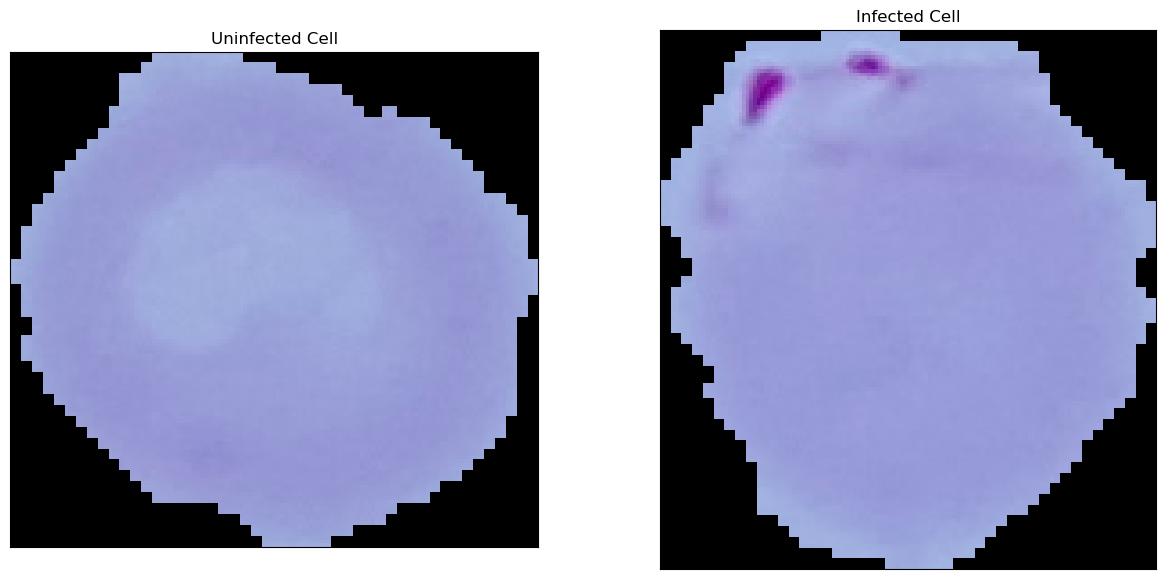

In [56]:
# import cv2 

uninf_example1='cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_131.png'
uninf_example2='cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_65.png'
uninf_example3='cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_25.png'

inf_example1='cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png'
inf_example2='cell_images/Parasitized/C100P61ThinF_IMG_20150918_145609_cell_146.png'
inf_example3='cell_images/Parasitized/C101P62ThinF_IMG_20150918_151507_cell_56.png'

plt.figure(6, figsize = (15 , 7))
plt.subplot(1 ,  2, 1)
plt.imshow(cv2.imread(uninf_example1))
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2, 2)
plt.imshow(cv2.imread(inf_example1))
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

# 3 - Divide Datasets into Training and Validation

In [61]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

Let's create our training and validation data generators. They will read batches of 16 images from the source, rescale them to a standardised size, and assign them a category.

In [63]:
width = 128
height = 128

trainDatagen = datagen.flow_from_directory(directory='cell_images/cell_images/',
                                           target_size=(width,height),
                                           class_mode = 'binary',
                                           batch_size = 16, # 22048/16=1378
                                           subset='training')

Found 22048 images belonging to 2 classes.


In [67]:
valDatagen = datagen.flow_from_directory(directory='cell_images/cell_images/',
                                           target_size=(width,height),
                                           class_mode = 'binary',
                                           batch_size = 16, # 5510/16=344
                                           subset='validation')

Found 5510 images belonging to 2 classes.


# 4 - Prepare CNN Model using Keras Sequential Model

**Goal**: Let's design a CNN to take coloured images (size 128x128, as standardised previously) and classify them into one of two categories (infected vs non-infected).

- Images have a height and width of 128 pixels and 3 channels (Red,Green,Blue; RBG). Thus each image has a 3D tensor (128,128,3).
- Layers will be added one after another, in a linear stack.
- Data will flow from input to output without looping back.

Convolution blocks, instead of dense layers, are very useful to preserve spatial relationships, without flattening their input. On top of that, they take fewer parameters, making them more efficient. Therefore, let's start by using convolution.

- **First Convolutional Block:**
  1) Add a 2D convolutional layer with 16 kernels of size 3x3. These will slide across the input image (a 128x128 pixel image containing 3 channels, i.e. RGB) and detect local patterns. Introduce non-linearity using RELU activation.
  2) Downsample feature maps with a MaxPool function: a 2x2 window will slide across the image and take the max value in each window. This will reduce spatial and computational requirements, also controlling overfitting.
  3) Implement Dropout to randomly select 20% of the neurons and set them to zero during training. This regularisation technique prevents overfitting.

- **Second Convolutional Block:**
  1) Add a 2D convolutional layer with 32 kernels of size 3x3. These will slide across the input image and detect local patterns. In this case the increased number of filters will allow the model to learn more abstract patterns. Introduce non-linearity using RELU activation.
  2) Downsample feature maps with a MaxPool function: a 2x2 window will slide across the image and take the max value in each window.
  3) Implement Dropout to randomly select 30% of the neurons and set them to zero during training. As the network goes deeper it is useful to increase Dropout to avoid overfitting.
- **Third Convolutional Block:**
  1) Add a 2D convolutional layer with 64 kernels of size 3x3. The increased number of filters will allow the model to learn very abstract patterns. Introduce non-linearity using RELU activation.
  2) Downsample feature maps with a MaxPool function: a 2x2 window will slide across the image and take the max value in each window.
  3) Implement Dropout to randomly select 30% of the neurons and set them to zero during training.
- **Transition Step (to Fully Connected Layers)** by taking previous 3D output and flattening it into a 1D vector. This is a required step before connecting to Dense layers.
- **Implement Fully Connected Layers:**
  1) Create a fully connected layer (dense layer) with 64 neurons. Each of these neurons will be connected to every output from the previous layer. RELU will be applied for non-linearity.
  2) Implement 50% Dropout as this is the final output layer. This forces the model not to rely on any particular feature, and helps reducing overfitting (especially in cases when training data is limited).
- **Get Output Layer** through one single neuron with sigmoid activation, thus retrieving a 0/1 binary classification. 

In [80]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,529 (3.15 MB)

 Trainable params: 826,529 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Now let's compile the model. This is crucial before training - we're setting up **how** and **what** to measure during model training and evaluation. To do so:

- Adaptive Moment Estimation (adam) optimizer: algorithm that will update the model's weights based on the loss function. It will use gradients calculated via backpropagation to decide where to move next in weight-space, thus reducing the loss.
- Binary Cross Entropy loss function: function used during binary classification training to measure how far off the model's predictions are from actual labels. The model tries to minimise this function by adjusting its weights.
- Accuracy metrics: the monitoring metrics, which will be used to evaluate performance (i.e. how many predictions are correct). Best used in balanced datasets.

Setting up early stop, we are defining a callback function that will monitor validation loss. If it stops improving for 2 consecutive epochs, it stops the training process early. Finally, if the model performance is declining, it will go back to the best parameters it found during the training process.

In [114]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=2, restore_best_weights=True)

Now let's compute the method that will train the model. We'll take our training data generator, defined above, and define how many batches of images (each batch consisting of 16 images) is passed through the model in each training instance (epoch). With 1378 images and a batch size of 16, it will take approximately 86 batches to finish one epoch. With 20 epochs, each image will be passed through the model 20 times. 

In [105]:
history = model.fit(trainDatagen,
                             steps_per_epoch = len(trainDatagen), #1378
                              epochs =20,
                              validation_data = valDatagen,
                              validation_steps=len(valDatagen), #345
                             callbacks=[early_stop])

Epoch 1/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - accuracy: 0.9577 - loss: 0.1379 - val_accuracy: 0.9419 - val_loss: 0.1663
Epoch 2/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - accuracy: 0.9586 - loss: 0.1402 - val_accuracy: 0.9423 - val_loss: 0.1757
Epoch 3/20
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - accuracy: 0.9588 - loss: 0.1268 - val_accuracy: 0.9470 - val_loss: 0.1702


Now let's plot these results to visually assess learning curves:

In [112]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

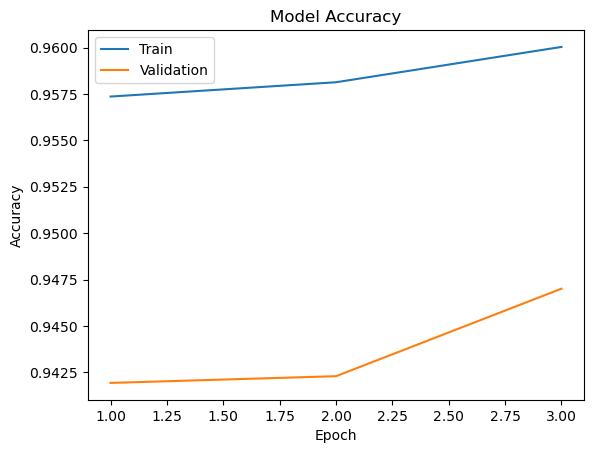

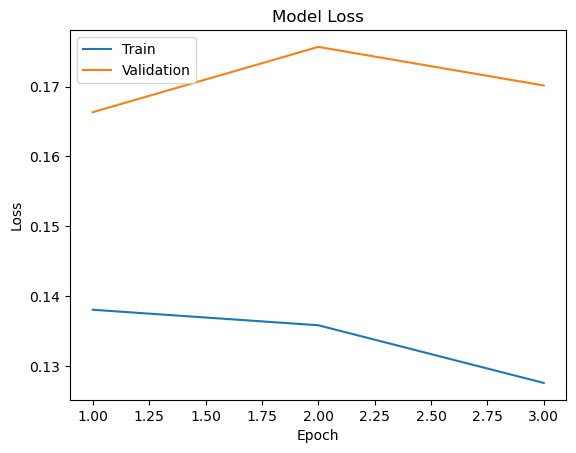

In [118]:
plotLearningCurve(history,3)